# 第十章：贝叶斯方法和K近邻分类

daitu

In [1]:
## 加载包
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
## 图像在jupyter notebook中显示
%matplotlib inline
## 显示的图片格式（mac中的高清格式），还可以设置为"bmp"等格式
%config InlineBackend.figure_format = "retina"
## 输出图显示中文
from matplotlib.font_manager import FontProperties
fonts = FontProperties(fname = "/Library/Fonts/华文细黑.ttf",size=14)

from sklearn import metrics
from sklearn.model_selection import train_test_split,GridSearchCV
## 忽略提醒
import warnings
warnings.filterwarnings("ignore")

from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.naive_bayes import MultinomialNB,GaussianNB,BernoulliNB
from sklearn.pipeline import Pipeline

## 垃圾邮件分类


https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

SMS Spam Collection Data Set 

In [2]:
## 读取邮件数据
spam = pd.read_csv("data/chap10/SMSSpamCollection",sep="\t",header=None)
spam.columns = ["classification","text"]
spam.head()

,classification,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
pd.value_counts(spam.classification)

ham     4825
spam     747
Name: classification, dtype: int64

In [4]:
# 将类别转化为数字
spam["label"] = spam.classification.map({'ham':0, 'spam':1})
spam.head()

,classification,text,label
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


### 绘制两种类型邮件的词云

观察两种类型的邮件的关键词差别

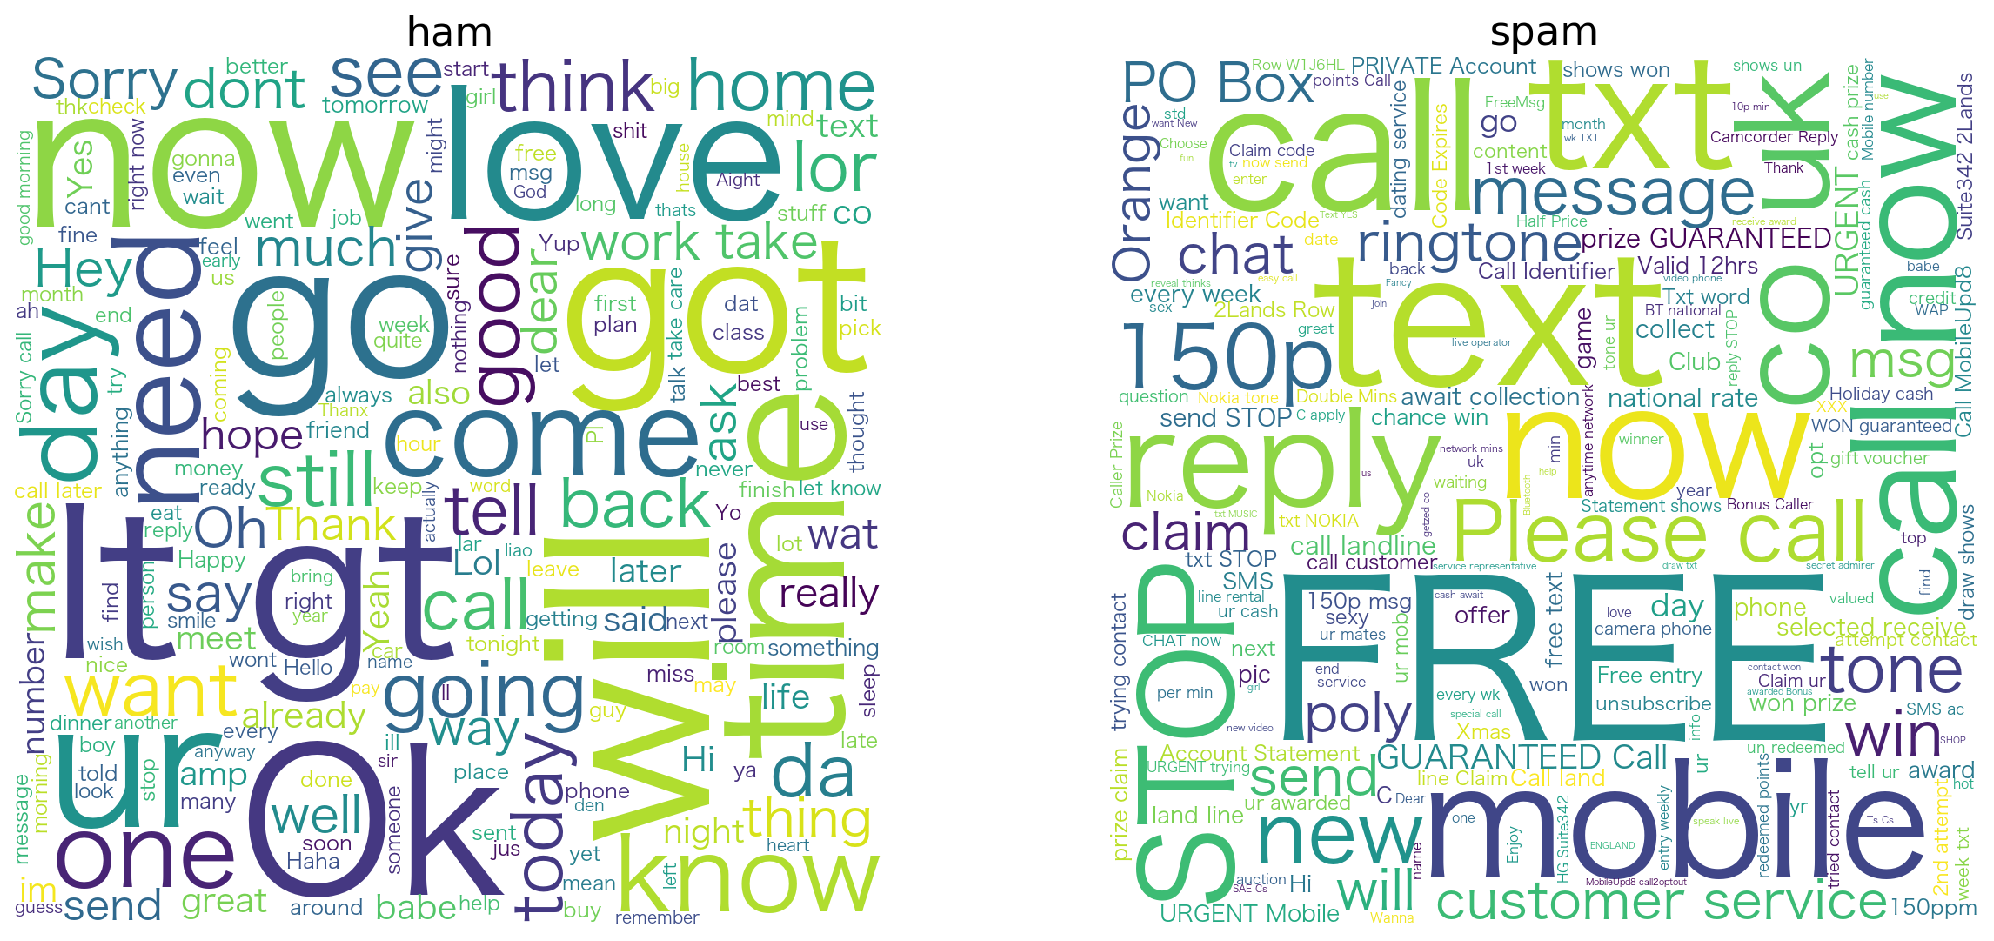

In [5]:
classification = ["ham","spam"]
plt.figure(figsize=(18,8))
for ii,cla in enumerate(classification):
    text = spam.text[spam.classification == cla]
    ## 设置词云参数
    WordC = WordCloud(font_path="/Library/Fonts/Hiragino Sans GB W3.ttc",
                        margin=1,width=1000, height=1000,
                        max_words=200, min_font_size=5, 
                        background_color='white',
                        max_font_size=250,)
    WordC.generate_from_text(" ".join(text))
    plt.subplot(1,2,ii+1)
    plt.imshow(WordC)
    plt.title(cla,size = 20)
    plt.axis("off")
plt.show()    

### 训练模型

In [6]:
## 切分数据集
train_x,test_x,train_y,test_y = train_test_split(spam.text,spam.label,test_size = 0.25, random_state=0)

In [7]:
pd.value_counts(train_y)
pd.value_counts(test_y)

0    1208
1     185
Name: label, dtype: int64

In [8]:
## 数据预处理,将英文根据空格将数据切分，统计词频TF，计算TFIDF
vectorizer = CountVectorizer(stop_words="english")    
transformer = TfidfTransformer()
train_tfidf = transformer.fit_transform(vectorizer.fit_transform(train_x))
train_tfidf.shape

(4179, 7287)

In [9]:
test_tfidf = transformer.transform(vectorizer.transform(test_x))
test_tfidf.shape

(1393, 7287)

**在scikit-learn中，一共有3个朴素贝叶斯的分类算法类。分别是GaussianNB，MultinomialNB和BernoulliNB。**

其中GaussianNB就是先验为高斯分布的朴素贝叶斯

MultinomialNB就是先验为多项式分布的朴素贝叶斯

BernoulliNB就是先验为伯努利分布的朴素贝叶斯


In [10]:
## 建立MultinomialNB就是先验为多项式分布的朴素贝叶斯
clf_m = MultinomialNB().fit(train_tfidf, train_y)
pre_ym = clf_m.predict(test_tfidf)
print(metrics.classification_report(test_y,pre_ym))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1208
           1       1.00      0.82      0.90       185

    accuracy                           0.98      1393
   macro avg       0.99      0.91      0.94      1393
weighted avg       0.98      0.98      0.97      1393



In [11]:
## 建立GaussianNB就是先验为高斯分布的朴素贝叶斯
clf_g = GaussianNB().fit(train_tfidf.toarray(), train_y)
pre_yg = clf_g.predict(test_tfidf.toarray())
print(metrics.classification_report(test_y,pre_yg))

              precision    recall  f1-score   support

           0       0.98      0.88      0.93      1208
           1       0.53      0.91      0.67       185

    accuracy                           0.88      1393
   macro avg       0.76      0.89      0.80      1393
weighted avg       0.92      0.88      0.89      1393



In [12]:
## 建立BernoulliNB就是先验为伯努利分布的朴素贝叶斯
clf_b = BernoulliNB().fit(train_tfidf, train_y)
pre_yb = clf_b.predict(test_tfidf)
print(metrics.classification_report(test_y,pre_yb))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1208
           1       1.00      0.83      0.91       185

    accuracy                           0.98      1393
   macro avg       0.99      0.92      0.95      1393
weighted avg       0.98      0.98      0.98      1393



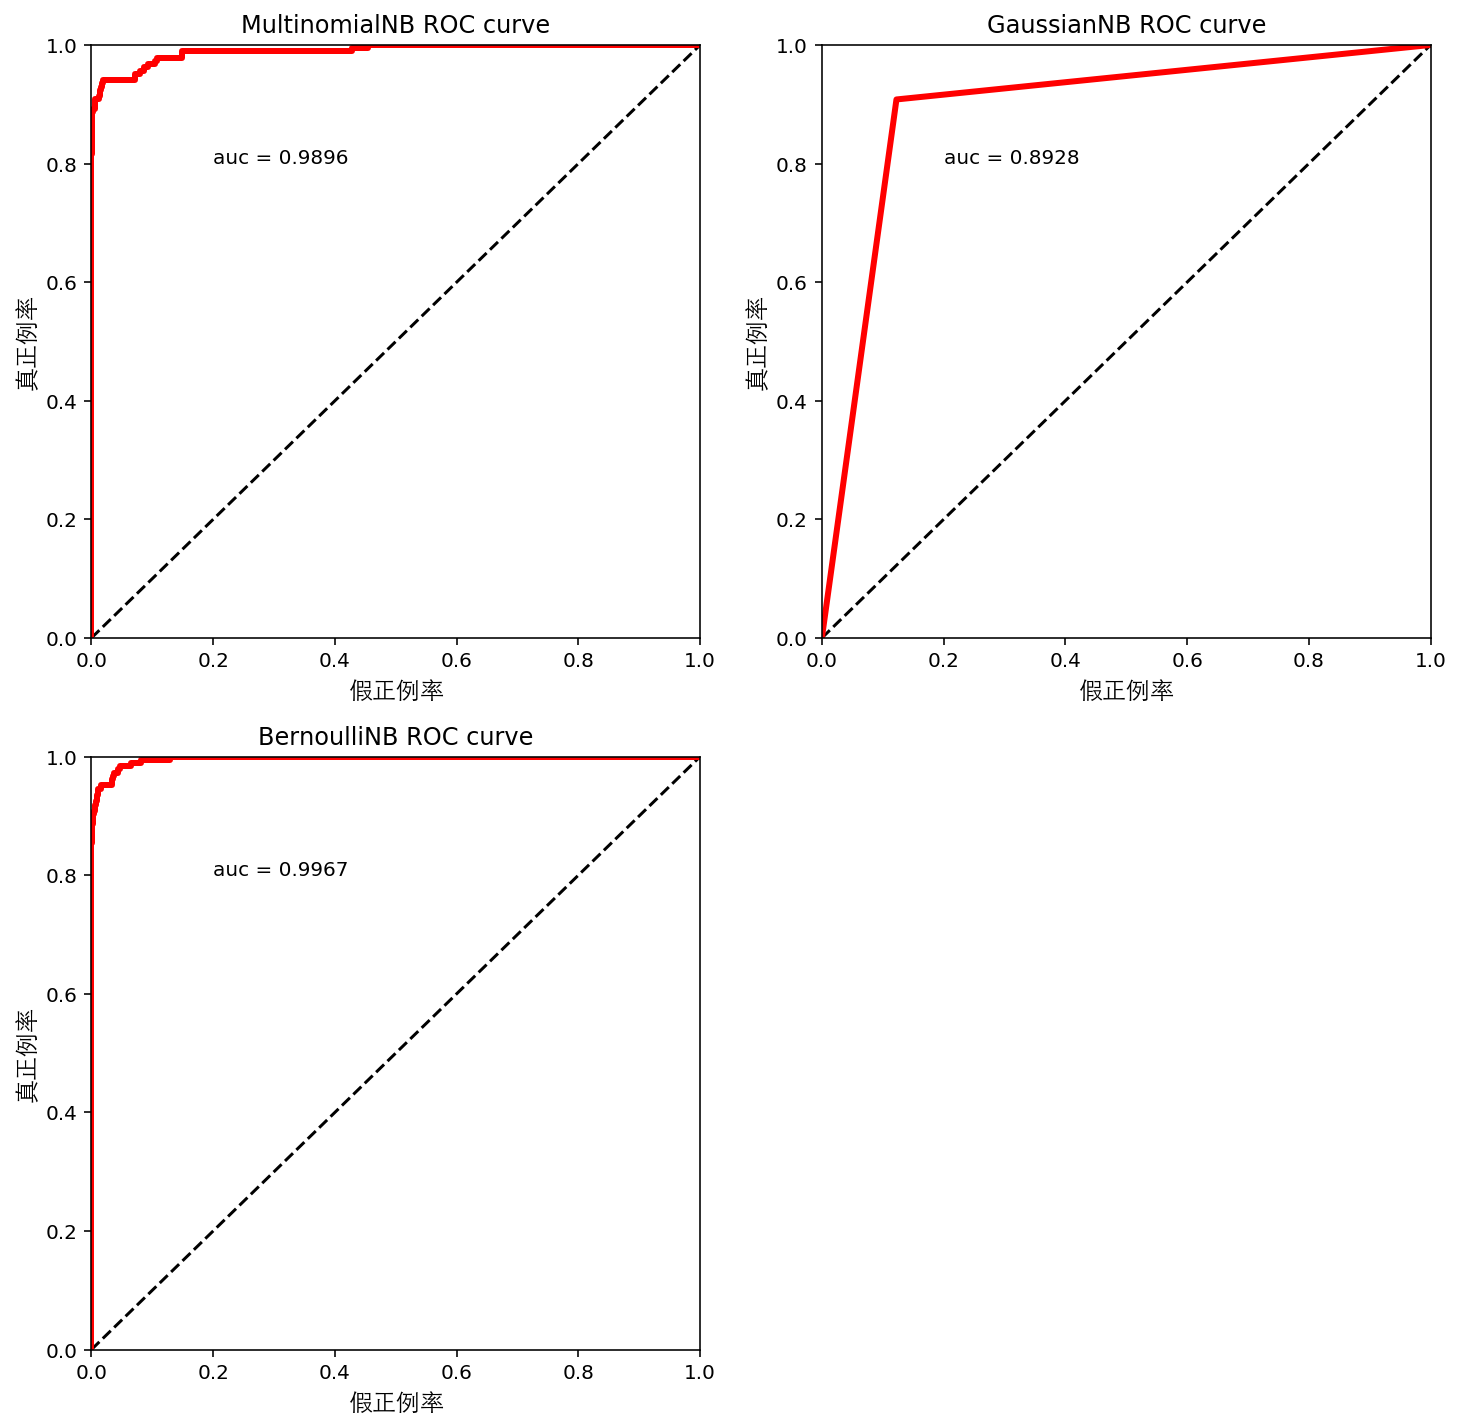

In [13]:
## plot ROC曲线
model = [clf_m,clf_g,clf_b]
modelname = ["MultinomialNB","GaussianNB","BernoulliNB"]
plt.figure(figsize=(12,12))
for ii,clf in enumerate(model):
    ## 计算预测概率
    pre_y = clf.predict_proba(test_tfidf.toarray())[:, 1]
    fpr_Nb, tpr_Nb, _ = metrics.roc_curve(test_y, pre_y)
    auc = metrics.auc(fpr_Nb, tpr_Nb)
    plt.subplot(2,2,ii+1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_Nb, tpr_Nb,"r",linewidth = 3)
    plt.xlabel("假正例率",fontproperties = fonts,size = 12)
    plt.ylabel("真正例率",fontproperties = fonts,size = 12)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.title(modelname[ii]+" ROC curve")
    plt.text(0.2,0.8,"auc = "+str(round(auc,4)))
plt.show()

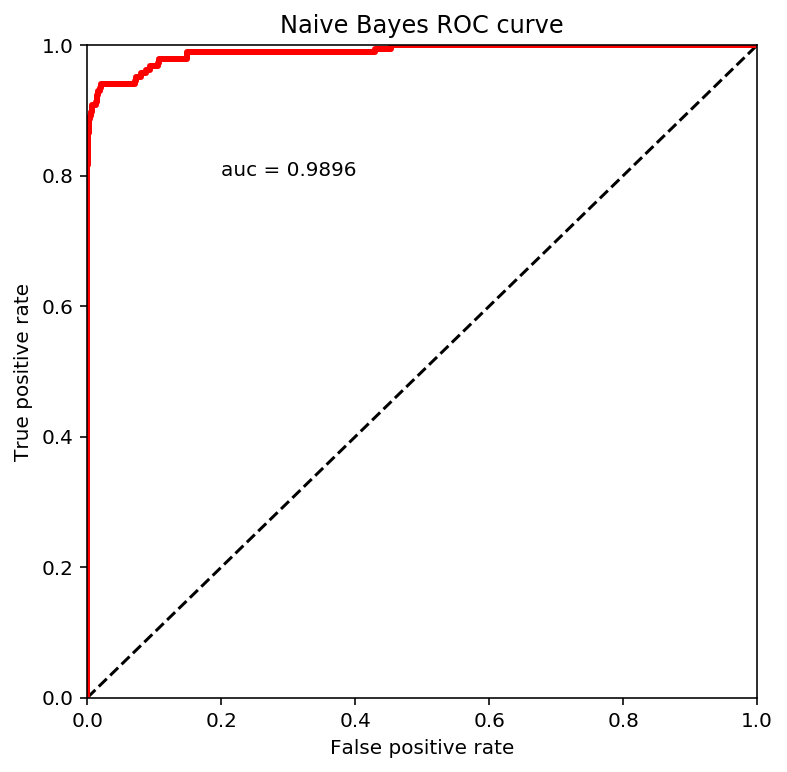

In [14]:
## plot ROC曲线
pre_y = clf_m.predict_proba(test_tfidf)[:, 1]
fpr_Nb, tpr_Nb, _ = metrics.roc_curve(test_y, pre_y)
auc = metrics.auc(fpr_Nb, tpr_Nb)
plt.figure(figsize=(6,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_Nb, tpr_Nb,"r",linewidth = 3)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title('Naive Bayes ROC curve')
plt.text(0.2,0.8,"auc = "+str(round(auc,4)))
plt.show()

### 模型优化，搜索参数找到最优的模型

In [15]:
## 对建模过程进行封装
spam_clf = Pipeline([('vect', CountVectorizer(stop_words="english")),
                      ('tfidf', TfidfTransformer()),
                      ('clf', MultinomialNB()),
                     ])

In [16]:
## 定义网格搜索的参数
alpha = [0.01,0.1,1,10,100]
para_grid = {'vect__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'clf__alpha': alpha,}

In [17]:
## 使用3折交叉验证进行搜索
gs_spam_clf = GridSearchCV(spam_clf,para_grid,cv=3,n_jobs=4)
gs_spam_clf.fit(train_x, train_y)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                            

In [18]:
## 得到最好的参数组合
gs_spam_clf.best_params_

{'clf__alpha': 0.1, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}

In [19]:
## 将输出的所有搜索结果进行处理
results = pd.DataFrame(gs_spam_clf.cv_results_)
## 输出感兴趣的结果
results2 = results[["mean_test_score","std_test_score","params"]]
results2

,mean_test_score,std_test_score,params
0,0.983728,0.002210,"{'clf__alpha': 0.01, 'tfidf__use_idf': True, '..."
1,0.986360,0.002923,"{'clf__alpha': 0.01, 'tfidf__use_idf': True, '..."
2,0.983728,0.002210,"{'clf__alpha': 0.01, 'tfidf__use_idf': False, ..."
3,0.985642,0.002105,"{'clf__alpha': 0.01, 'tfidf__use_idf': False, ..."
4,0.984446,0.001877,"{'clf__alpha': 0.1, 'tfidf__use_idf': True, 'v..."
5,0.987796,0.001546,"{'clf__alpha': 0.1, 'tfidf__use_idf': True, 'v..."
6,0.984207,0.002107,"{'clf__alpha': 0.1, 'tfidf__use_idf': False, '..."
7,0.985164,0.000890,"{'clf__alpha': 0.1, 'tfidf__use_idf': False, '..."
8,0.961953,0.005195,"{'clf__alpha': 1, 'tfidf__use_idf': True, 'vec..."
9,0.949031,0.004414,"{'clf__alpha': 1, 'tfidf__use_idf': True, 'vec..."


## K-近邻模型

使用k近邻算法对信用卡数据集进行建模判别。

解决数据不平衡问题主要有3中方式：

1:对于少的样本重复采样——过采样

2:对于多的样本采样使用较少的数据进行训练——欠采样

3:使用数据集的近邻对较少的样本生成新的数据集，如smote方法

针对该数据集我们主要使用第三种，对样本少的数据生成新的样本。即使用smote方法解决数据不平衡问题

In [20]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.combine import SMOTEENN
from imblearn.ensemble import BalanceCascade 

In [21]:
## 读取数据集
credit = pd.read_excel("data/chap10/default of credit card clients.xls")
credit.head(5)

,ID,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [22]:
## 数据标准化
creditX = StandardScaler().fit_transform(credit.drop(["ID","Y"],axis = 1))
## 首先对数据进行主成分分析提取主成分
pca = PCA(n_components=15)
credit_pca = pca.fit_transform(creditX)

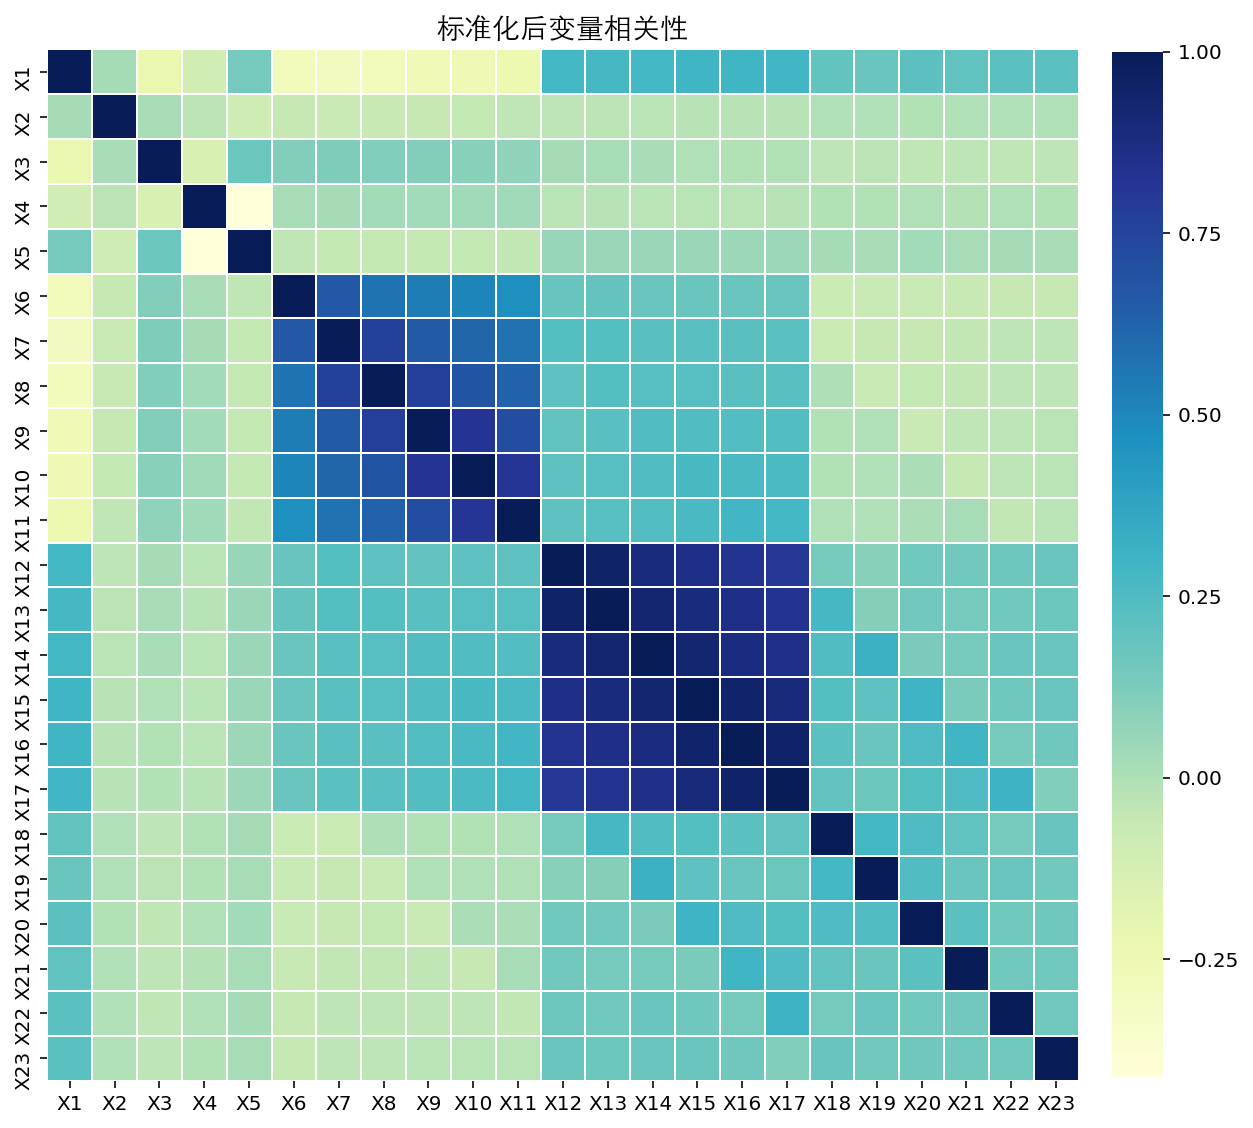

In [23]:
## 对23个标准化后变量数据进行相关系数可视化
datacor = np.corrcoef(creditX,rowvar=0)
x = credit.drop(["ID","Y"],axis = 1)
datacor = pd.DataFrame(data=datacor,columns=x.columns,index=x.columns)
## 热力图可视化相关系数
plt.figure(figsize=(10,10))
ax = sns.heatmap(datacor,square=True,
                 linewidths=.5,cmap="YlGnBu",
                 cbar_kws={"fraction":0.046, "pad":0.03})
ax.set_title("标准化后变量相关性",fontproperties = fonts)
plt.show()
## 从图上可以看出我们的变量之间具有很强的自相关性，而且相关性是呈区域的

In [24]:
## 前15个主成分的累计贡献率为95%
print(np.sum(pca.explained_variance_ratio_))
np.round(pca.explained_variance_ratio_,6)

0.9570022822560613


array([0.284482, 0.178188, 0.067433, 0.064012, 0.044576, 0.041617,
       0.03946 , 0.038592, 0.03788 , 0.03404 , 0.03186 , 0.029688,
       0.024824, 0.0228  , 0.01755 ])

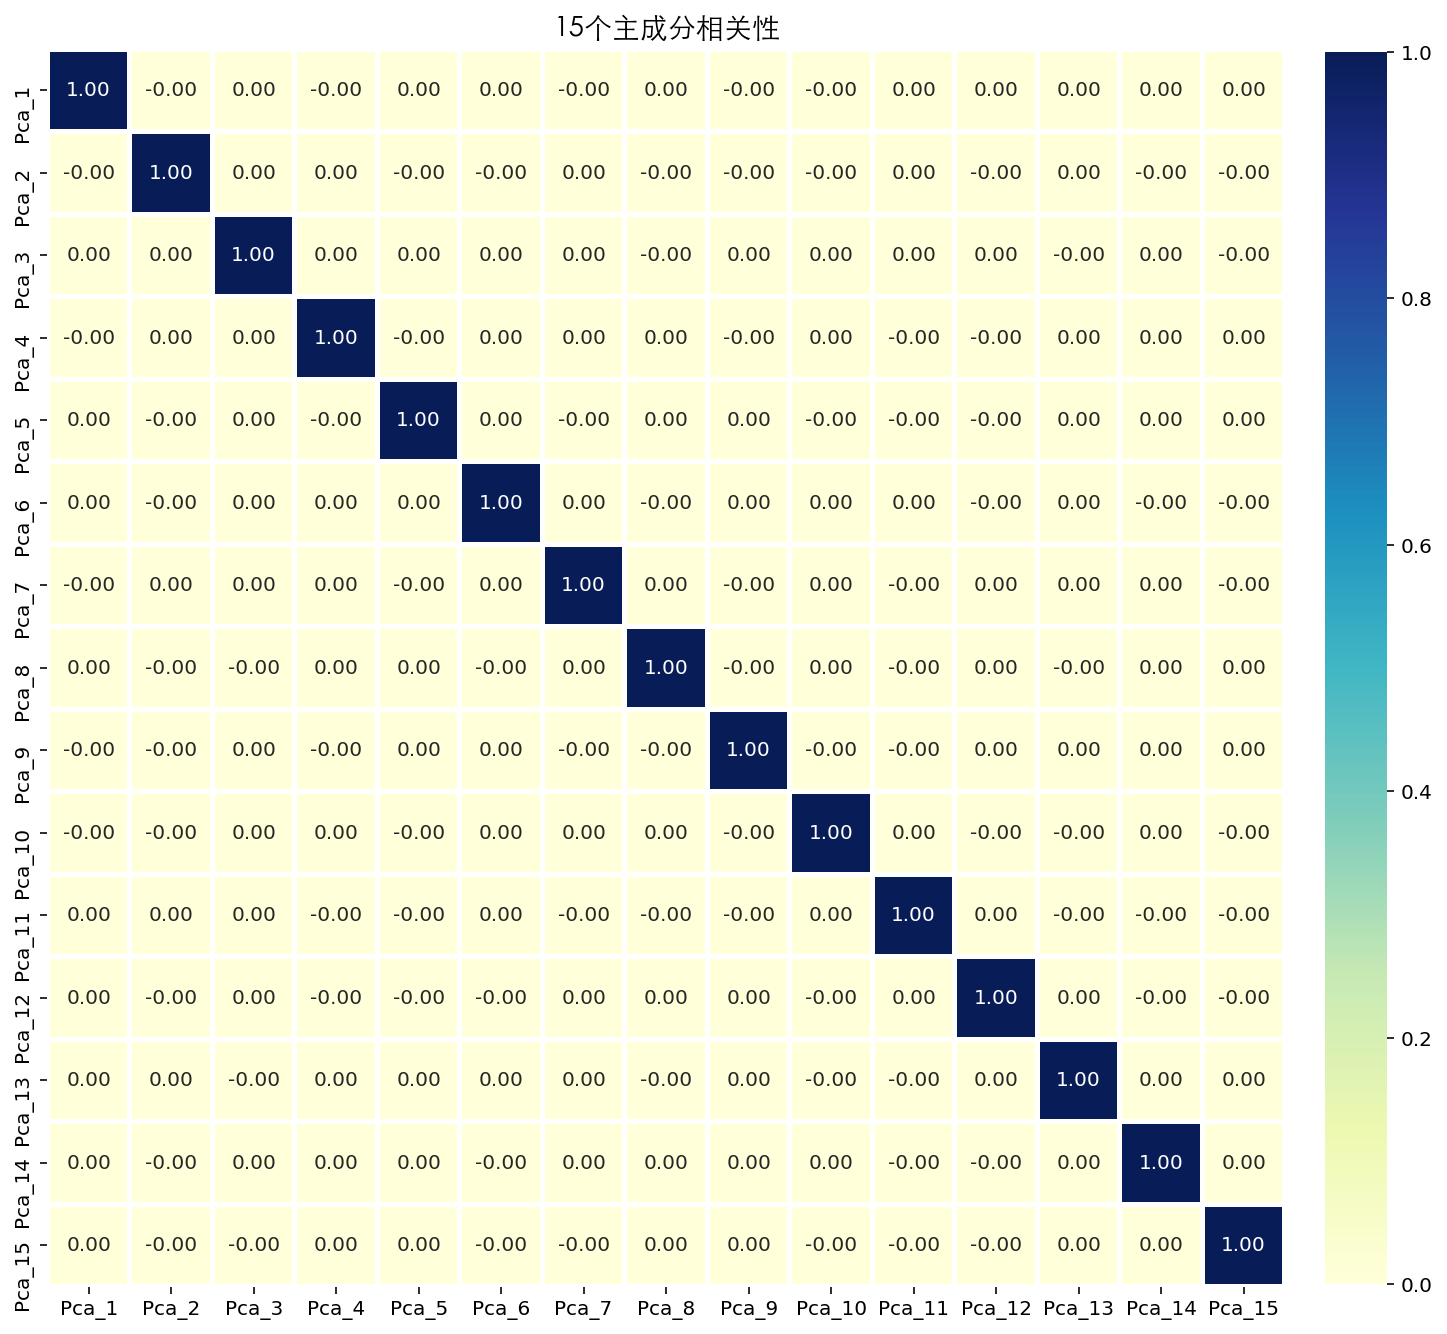

In [25]:
## 使用主成分分析的一个好处时可以消除变量之间的相关性，因为得到的主成分都是不相关的，可以使用热力图查看
## 对23个主成分进行相关系数可视化
datacor = np.corrcoef(credit_pca,rowvar=0)
name = ["Pca_"+str((ii)) for ii in np.arange(1,16)]
datacor = pd.DataFrame(data=datacor,columns=name,index=name)
## 热力图可视化相关系数
plt.figure(figsize=(12,12))
ax = sns.heatmap(datacor,square=True,annot=True,fmt = ".2f",
                 linewidths=2,cmap="YlGnBu",
                 cbar_kws={"fraction":0.046, "pad":0.03})
ax.set_title("15个主成分相关性",fontproperties = fonts)
plt.show()

In [26]:
pd.value_counts(credit.Y)

0    23364
1     6636
Name: Y, dtype: int64

In [27]:
## 切分数据集
cp_train_x,cp_test_x,cp_train_y,cp_test_y = train_test_split(credit_pca,credit.Y,test_size = 0.2, random_state=0)
pd.value_counts(cp_train_y)

0    18661
1     5339
Name: Y, dtype: int64

### 数据平衡后操作


In [28]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.combine import SMOTEENN
from imblearn.ensemble import BalanceCascade 

In [29]:
## 对降维后的主成分数据训练集进行数据平衡
sm = SMOTE(random_state=42,k_neighbors=5)
train_xs,train_ys = sm.fit_sample(cp_train_x,cp_train_y)
pd.value_counts(train_ys)

1    18661
0    18661
dtype: int64

In [30]:
## 欠抽样
Nm = NearMiss(random_state = 42,ratio="auto")
train_xNm,train_yNm = Nm.fit_sample(cp_train_x,cp_train_y)
pd.value_counts(train_yNm)

1    5339
0    5339
dtype: int64

In [31]:
## 组合方法，欠抽样和过抽样同时进行
SE = SMOTEENN(random_state = 42,ratio="auto")
train_xSE,train_ySE = SE.fit_sample(cp_train_x,cp_train_y)
pd.value_counts(train_ySE)

1    14109
0     9592
dtype: int64

In [32]:
## 组合方法，将数据集切分位了4个
BC = BalanceCascade(random_state = 42,ratio="auto")
train_xBC,train_yBC = BC.fit_sample(cp_train_x,cp_train_y)
print(train_xBC.shape)
pd.value_counts(train_yBC[0,:])

(4, 10678, 15)


1    5339
0    5339
dtype: int64

### KNN + 4种数据平衡后的数据

In [33]:
## 使用k近邻建模 ＋ 过抽样
kcl = KNeighborsClassifier(n_neighbors=9)
kcl.fit(train_xs,train_ys)
kcl_pre_s = kcl.predict(cp_test_x)
metrics.confusion_matrix(cp_test_y,kcl_pre_s)

array([[3173, 1530],
       [ 460,  837]])

In [34]:
metrics.accuracy_score(cp_test_y,kcl_pre_s)

0.6683333333333333

In [35]:
print(metrics.classification_report(cp_test_y,kcl_pre_s))

              precision    recall  f1-score   support

           0       0.87      0.67      0.76      4703
           1       0.35      0.65      0.46      1297

    accuracy                           0.67      6000
   macro avg       0.61      0.66      0.61      6000
weighted avg       0.76      0.67      0.70      6000



#### kNN＋ 欠抽样

In [36]:
## 使用k近邻建模 ＋ 欠抽样
kcl.fit(train_xNm,train_yNm)
kcl_pre_Nm = kcl.predict(cp_test_x)
metrics.confusion_matrix(cp_test_y,kcl_pre_Nm)

array([[2775, 1928],
       [ 460,  837]])

In [37]:
metrics.accuracy_score(cp_test_y,kcl_pre_Nm)

0.602

In [38]:
print(metrics.classification_report(cp_test_y,kcl_pre_Nm))

              precision    recall  f1-score   support

           0       0.86      0.59      0.70      4703
           1       0.30      0.65      0.41      1297

    accuracy                           0.60      6000
   macro avg       0.58      0.62      0.56      6000
weighted avg       0.74      0.60      0.64      6000



#### kNN＋ 欠抽样+过抽样

In [39]:
## 使用k近邻建模 ＋ 欠抽样
kcl.fit(train_xSE,train_ySE)
kcl_pre_SE = kcl.predict(cp_test_x)
metrics.confusion_matrix(cp_test_y,kcl_pre_SE)

array([[2706, 1997],
       [ 337,  960]])

In [40]:
metrics.accuracy_score(cp_test_y,kcl_pre_SE)

0.611

In [41]:
print(metrics.classification_report(cp_test_y,kcl_pre_SE))

              precision    recall  f1-score   support

           0       0.89      0.58      0.70      4703
           1       0.32      0.74      0.45      1297

    accuracy                           0.61      6000
   macro avg       0.61      0.66      0.58      6000
weighted avg       0.77      0.61      0.65      6000



In [42]:
## 找到不同的stoms参数和knn参数的最优效果
## 初始化数据
number = 20
k_neighbors = np.arange(1,number)
n_neighbors = np.arange(1,number)
kk,nn = np.meshgrid(k_neighbors,n_neighbors)
kki = kk.flatten()
nni = nn.flatten()
scoresi = np.random.random(kki.shape)
for ii in range(len(kki)):
    ## 平衡数据
    sm = SMOTE(random_state=42,k_neighbors=kki[ii])
    train_xs,train_ys = sm.fit_sample(cp_train_x,cp_train_y)
    kcl = KNeighborsClassifier(n_neighbors=nni[ii])
    kcl.fit(train_xs,train_ys)
    ## 计算score
    kcl_pre = kcl.predict(cp_test_x)
    scoresi[ii] = metrics.accuracy_score(cp_test_y,kcl_pre)
      

In [44]:
max(scoresi)

0.7423333333333333

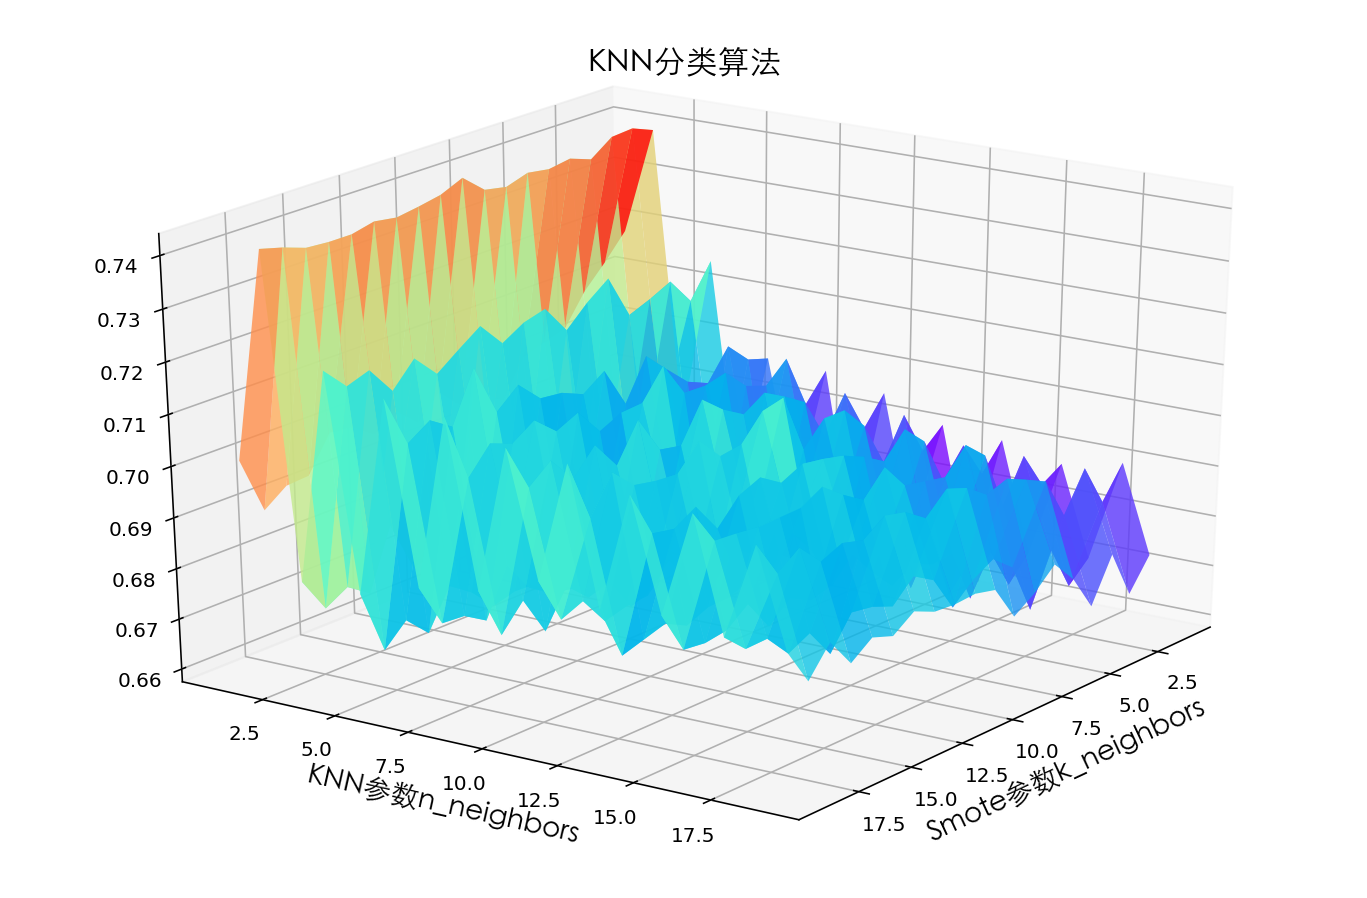

In [45]:
scores = scoresi.reshape(kk.shape)
## 可视化查看模型效果
fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(111,projection="3d")
## 绘制曲面图，rstride:行的跨度, cstride:列的跨度, cmap:颜色,alpha:透明度
ax.plot_surface(kk, nn, scores,alpha= 0.8,cmap=plt.cm.rainbow)
ax.set_xlabel("Smote参数k_neighbors",fontproperties = fonts)
ax.set_ylabel("KNN参数n_neighbors",fontproperties = fonts)
ax.set_title("KNN分类算法",fontproperties = fonts,size = 16)
ax.view_init(25,35)
plt.show()

可见knn的近邻数对模型的效果影响更大
